#### Importing packages

In [79]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import plotly as py
import plotly.express as px
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
# to avoid warnings
from sklearn.metrics import accuracy_score,recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

#### Functions

In [80]:
# Function to remove missing values above a given threshold
def missing_remove(dataframe, threshold):
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold].tolist()
    print(f"# Features deleted with more than {threshold} % missing values", len(columns))
    return dataframe.drop(columns, axis=1,inplace=True)

In [81]:
# Function to remove features with unique values
def unique_remove(dataframe):
    unique_features = []
    for col in dataframe.columns:
        if(dataframe[col].unique().size == 2):
            if(len(unique_features) == 0):
                unique_features =  dataframe[col]
            else:
                 unique_features = pd.concat([unique_features, dataframe[col]], axis=1)
            dataframe.drop(col, axis=1, inplace=True)

In [82]:
# Function to remove outlier
def outlier_detection_zcore(dataframe):
    data_mean, data_std  = dataframe.mean(), dataframe.std()
    data_z_scores = ((dataframe - data_mean) / data_std).abs()
    m = data_z_scores > 3
    dataframe = dataframe.mask(m,inplace=True)
    return dataframe

In [83]:
def rfc(X_train_rfc,X_test_rfc,y_train,max_depth):
  from matplotlib.pyplot import figure
  figure(figsize=(8, 5), dpi=80)
  model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=max_depth)
  model.fit(X_train_rfc, y_train)
  y_pred = model.predict(X_test_rfc)
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",yticklabels = ['Act. Fail', 'Act. Pass'], xticklabels = ['Pred. Fail' , 'Pred. Pass'])
  print(classification_report(y_test, y_pred))
  ax = plt.gca()
  plot = plot_roc_curve(model, X_test_rfc, y_test, ax=ax, alpha=0.8)
  print("Test Accuracy Score", accuracy_score(y_test, y_pred))
  f1score = f1_score(y_test, y_pred, average='micro')
  mccscore=matthews_corrcoef(y_test, y_pred)
  return f1score, mccscore

In [84]:
def evaluate2(model, X_train,X_test,y_train,y_test):
  from matplotlib.pyplot import figure
  figure(figsize=(8, 5), dpi=80)

  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train_std = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
  X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

  model.fit(X_train_std, y_train)
  y_pred = model.predict(X_test_std)
  cm=confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt="d",cmap="YlOrRd",yticklabels = ['Act. Pass', 'Act. Fail'], xticklabels = ['Pred. Pass' , 'Pred. Fail'])
  #print(classification_report(y_test, y_pred))
  ax = plt.gca()
  plot = plot_roc_curve(model, X_test_std, y_test, ax=ax, alpha=0.8)
  print("Model Name:", model)
  print("Train Accuracy Score:", accuracy_score(y_train, model.predict(X_train_std)))
  print("Test Accuracy Score:", accuracy_score(y_test, y_pred))
  f1score = f1_score(y_test, y_pred, average='micro')
  mccscore=matthews_corrcoef(y_test, y_pred)
  recall = recall_score(y_test,y_pred)
  precision = precision_score(y_test,y_pred)
  specificity = cm[1,1]/(cm[1,1]+cm[0,1])
  sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
  FNR = cm[1,0]/(cm[1,0]+cm[0,0])
  FPR = cm[0,1]/(cm[0,1]+cm[1,1])
  specificity1 = 1 - FPR
  sensitivity1 = 1- FNR
  print("F1 Score:", f1score) 
  print("MC Score:" , mccscore)
  print("Sensitivity:" , sensitivity)
  print("Specificity:" , specificity)
  print("Recall:" , recall)
  print("Precision:" , precision)
  print("FNR:" , FNR)
  print(f"FPR: {FPR}\n" )
  #print("Sensitivity1:" , sensitivity1)
  #print("Specificity1:" , specificity1)


In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, matthews_corrcoef
from yellowbrick.classifier import ConfusionMatrix, ClassPredictionError
def evaluate(train_df, test_df, train_target, test_target):
    
    scaler = StandardScaler()
    scaler.fit(train_df)
    train_std = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
    test_std = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
    
    logreg = LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear')
    logreg.fit(train_std, train_target.values.ravel())
    
    y_pred = logreg.predict(test_std)
    y_true = test_target.values.ravel()
    f1score = f1_score(y_true, y_pred, average='micro')
    mccscore=matthews_corrcoef(y_true, y_pred)
    
   
    cm = ConfusionMatrix(logreg, classes=['Fail', 'Pass'], cmap="YlGn", size=(400,400))
    cm.score(test_std, y_true)
    cm.show()
    from matplotlib.pyplot import figure
    figure(figsize=(5, 5), dpi=80)
    ax = plt.gca()
    plot = plot_roc_curve(logreg, test_df, test_target, ax=ax, alpha=0.8)
    
    return f1score, mccscore

#### Importing and basic cleaning

In [86]:
# Importing data from internet in runtime
data_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"

In [87]:
# Assigning data to a pandas dataframe
secom_data = pd.read_csv(data_url,sep=' ',header=None)

In [88]:
# Renaming the columns 
secom_data.columns = ["Feature_"+str(column+1) for column in range(len(secom_data.columns))]
secom_data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_581,Feature_582,Feature_583,Feature_584,Feature_585,Feature_586,Feature_587,Feature_588,Feature_589,Feature_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [89]:
# Importing target data from internet in runtime
label_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

In [90]:
# Assigning target data to a pandas dataframe
secom_labels = pd.read_csv(label_url, sep = " ",header=None)

In [91]:
# Renaming the columns 
secom_labels.columns = ["Classification","Timestamp"]

In [92]:
# Changing datatype for consitency
secom_labels['Timestamp'] = pd.to_datetime(secom_labels['Timestamp'],errors='raise')

In [93]:
# Merging the data
data= pd.concat([secom_labels,secom_data],axis=1)

In [94]:
# Dropping the timestamp column as it provides no insights
data.drop(columns="Timestamp", errors='raise',inplace=True)

In [95]:
target = data[['Classification']]
data.drop(['Classification'], axis=1,inplace=True)

#### Spliting the data into training set and test set

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.20, random_state=42, stratify=target)
# We use the startify parameter as the data is imbalanced on the basis of pass and fail and this will ensure the same 
#is retained when we split - Random state will help us create a reproducible data - Test size is the split ration

In [97]:
X_test_original = X_test

#### Re-labeling the Target values


In [98]:
# Relabeling target variables 1 is pass and 0 is fail
# y_train = y_train.replace(to_replace=[-1, 1], value=[1, 0])
# y_test = y_test.replace(to_replace=[-1, 1], value=[1, 0])

In [99]:
# # Scaling the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Decision : Removing columns with more that 50% missing values

In [100]:
X_train.shape

(1253, 590)

In [101]:
X_train_missing = X_train
missing_remove(X_train_missing, 0.5)
X_train_missing.shape

# Features deleted with more than 0.5 % missing values 32


(1253, 558)

In [102]:
# From test set deleting columns that are removed in training set
X_test_missing = X_test[np.array(X_train_missing.columns)]
X_test_missing.shape

(314, 558)

# Decision : Replacing outliers with 3s boundary

##### Other option of removing outliers and replacing them has been explored in file "Base file - removing outliers and replacing with knn.ipynb"

In [103]:
def replace_outlier(val, mean, std):
    if val > mean + 3*std:
        return mean + 3*std 
    elif val < mean - 3*std:
        return mean - 3*std
    return val

In [104]:
# replace with 3s in X_train
for col in X_train_missing.columns:
    mean = X_train_missing[col].mean()
    std_dev = X_train_missing[col].std(axis=0)
    X_train_missing[col] = X_train_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

In [105]:
# replace with 3s in X_test
for col in X_test_missing.columns:
    mean = X_test_missing[col].mean()
    std_dev = X_test_missing[col].std(axis=0)
    X_test_missing[col] = X_test_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

# KNN Imputation

In [106]:
from sklearn.impute import KNNImputer
knn = KNNImputer()
knn.fit(X_train_missing)
X_train_knn=pd.DataFrame(knn.transform(X_train_missing), columns=X_train_missing.columns)
X_train_knn.isna().sum().sum()

0

In [107]:
from sklearn.impute import KNNImputer
knn = KNNImputer()
knn.fit(X_test_missing)
X_test_knn=pd.DataFrame(knn.transform(X_test_missing), columns=X_test_missing.columns)
X_test_knn.isna().sum().sum()

0

# Feature Selection

## Chi square with p values less than 0.4

In [108]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
normalized_x_train = X_train_knn.copy()
normalized_x_train[normalized_x_train.columns] = MinMaxScaler().fit_transform(normalized_x_train[normalized_x_train.columns])
normalized_x_train

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_577,Feature_578,Feature_583,Feature_584,Feature_585,Feature_586,Feature_587,Feature_588,Feature_589,Feature_590
0,0.639471,0.488470,0.414807,0.248764,0.000738,0.0,0.623446,0.744809,0.380047,0.303514,...,0.003688,0.256187,0.384639,0.095324,0.091048,0.094178,0.508546,0.188698,0.191578,0.124543
1,0.630936,0.485141,0.597504,0.362507,0.007906,0.0,0.634340,0.718635,0.686878,0.557810,...,0.008206,0.139712,0.533517,0.379783,0.322171,0.366874,0.649787,0.059453,0.095789,0.044107
2,0.507583,0.557174,0.505181,0.085899,0.005383,0.0,0.642167,0.754624,0.311809,0.474608,...,0.010163,0.263825,0.503741,0.048418,0.042022,0.048467,0.648455,0.524736,0.462980,0.189274
3,0.243054,0.651552,0.634422,0.525094,0.009660,0.0,0.379896,0.852774,0.851424,0.289452,...,0.013497,0.180895,0.533517,0.164926,0.098052,0.159801,0.477899,0.447189,0.407103,0.271274
4,0.427843,0.438097,0.032682,0.092939,0.005517,0.0,0.640736,0.892035,0.480711,0.367967,...,0.006068,0.203891,0.444190,0.161899,0.126067,0.158271,0.708415,0.121491,0.159648,0.055724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.601975,0.516164,0.623353,0.426772,0.006226,0.0,0.447160,0.790612,0.396018,0.547264,...,0.018374,0.090021,0.602993,0.597666,0.539286,0.574544,0.195417,0.485962,0.494910,0.000000
1249,0.442290,0.425718,0.375060,0.117232,0.000899,0.0,0.574367,0.813514,0.822145,0.154687,...,0.007120,0.122471,0.394564,0.125585,0.084045,0.122442,0.599154,0.266245,0.279385,0.122816
1250,0.412210,0.543150,0.287202,0.167533,0.005498,0.0,0.477785,0.842959,0.613800,0.244921,...,0.003648,0.257318,0.483891,0.075654,0.091048,0.074573,0.609813,0.100811,0.079824,0.062559
1251,0.303624,0.555343,0.559204,0.240438,0.004230,0.0,0.545408,0.721907,0.489180,0.332811,...,0.016797,0.053936,0.593068,0.143742,0.105056,0.138746,0.276698,0.289509,0.295350,0.775957


In [109]:
from sklearn.feature_selection import SelectKBest, chi2
f_score = chi2(normalized_x_train,y_train)
p_values = pd.Series(f_score[1])
p_values.index = normalized_x_train.columns
p_values.sort_values(ascending=True,inplace=True)
significant = p_values[0:29]
new = list(significant.index)
X_train_chi = X_train_knn.loc[:, new]

In [110]:
# From test set deleting columns that are removed in training set
X_test_chi = X_test_knn[np.array(X_train_chi.columns)]
X_test_chi.shape

(314, 29)

Text(0.5, 1.0, 'Heatmap for the Data')

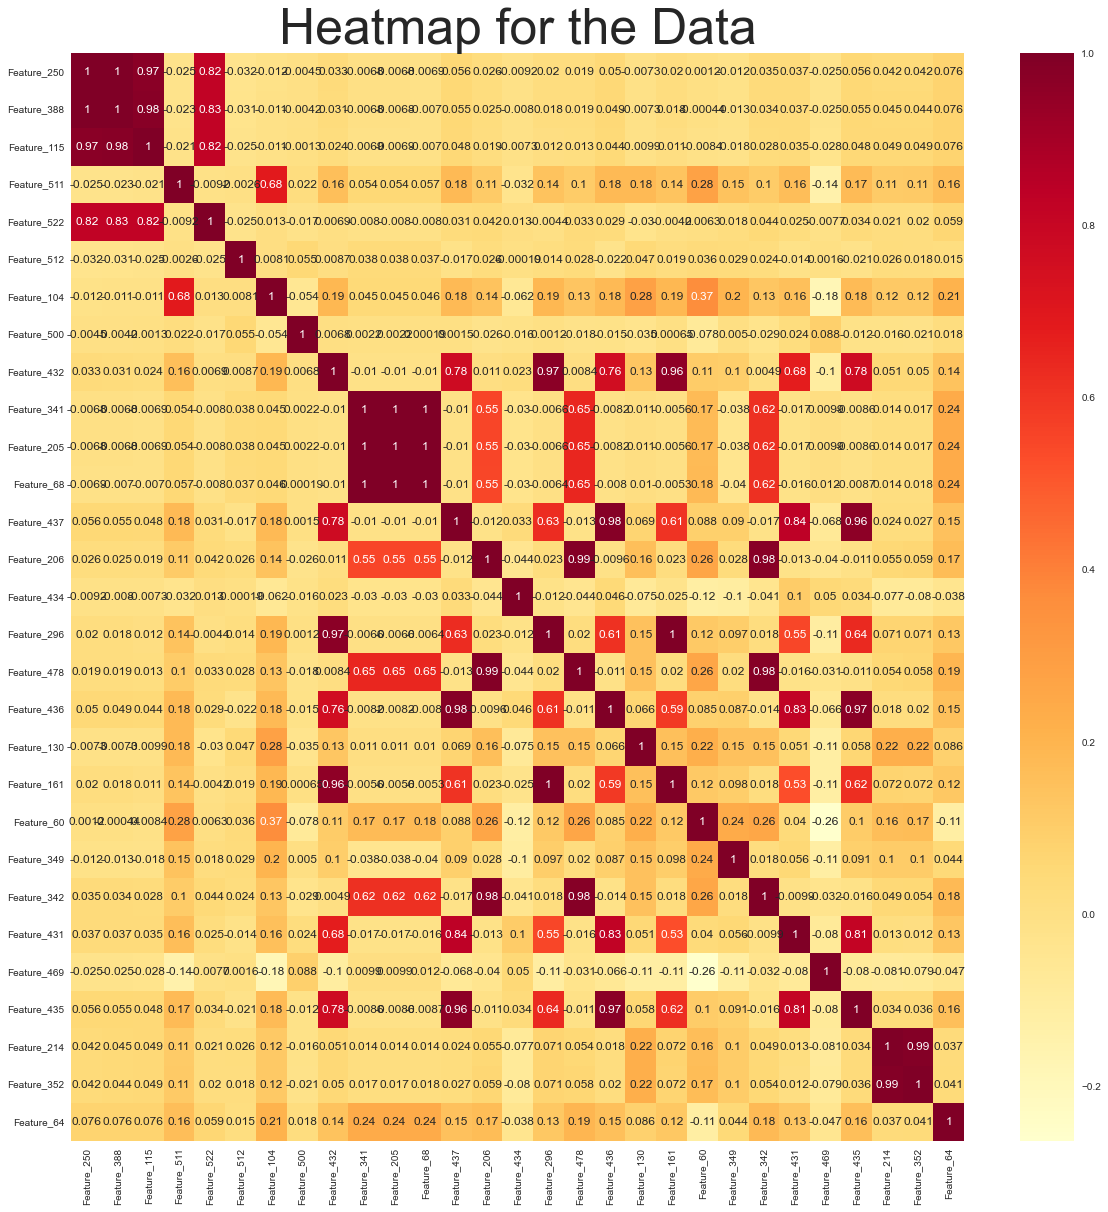

In [111]:
import seaborn as sns
# Heatmap for correlation
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(X_train_chi.corr(),cmap="YlOrRd",annot=True)
plt.title('Heatmap for the Data', fontsize = 50)

## Balancing usnig SMOTE

In [112]:
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

In [113]:
from imblearn.combine import SMOTETomek 
# Sampling technique

def Sampling(X_train, y_train, sampler):

    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)        

   
    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
        
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)
        

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [114]:
# Imbalance treatment
from collections import Counter
X_smote, y_smote = Sampling(X_train_chi, y_train,'SMOTE')

Counter({'Classification': 1})


Model Name: LogisticRegression(C=200, class_weight='balanced', random_state=42,
                   solver='liblinear')
Train Accuracy Score: 0.7465811965811966
Test Accuracy Score: 0.7420382165605095
F1 Score: 0.7420382165605095
MC Score: 0.16008605834119974
Sensitivity: 0.9568965517241379
Specificity: 0.13414634146341464
Recall: 0.5238095238095238
Precision: 0.13414634146341464
FNR: 0.04310344827586207
FPR: 0.8658536585365854

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
Train Accuracy Score: 0.9141025641025641
Test Accuracy Score: 0.8152866242038217
F1 Score: 0.8152866242038217
MC Score: 0.12405592068342924
Sensitivity: 0.9467680608365019
Specificity: 0.13725490196078433
Recall: 0.3333333333333333
Precision: 0.13725490196078433
FNR: 0.053231939163498096
FPR: 0.8627450980392157

Model Name: SVC()
Train Accuracy Score: 0.8935897435897436
Test Accuracy Score: 0.8057324840764332
F1 Score: 0.80573248

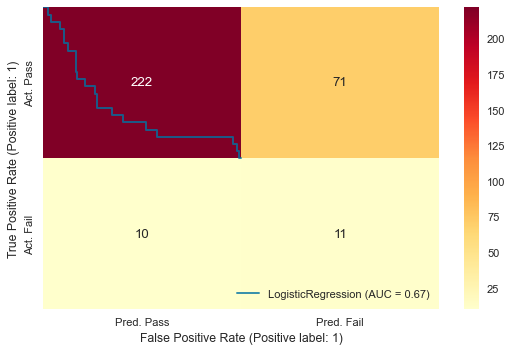

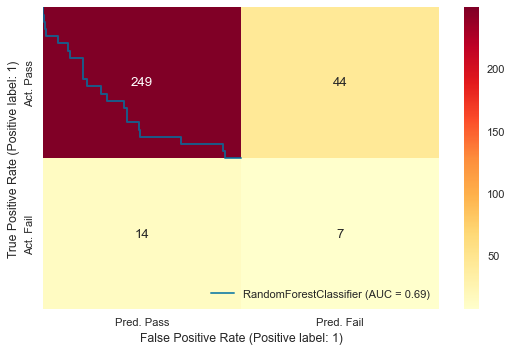

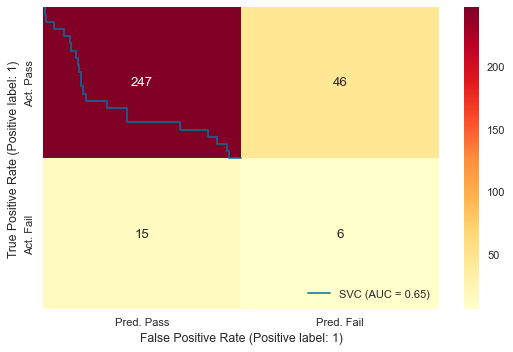

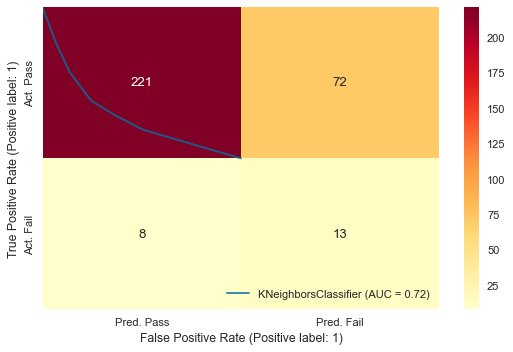

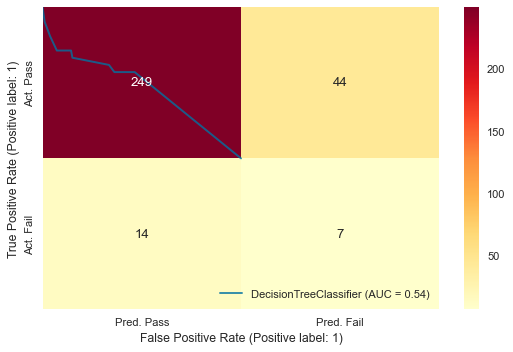

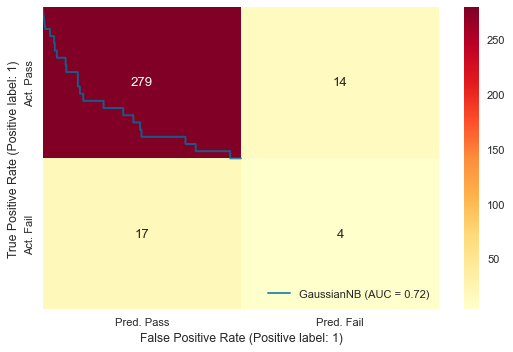

In [115]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB

evaluate2(LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear'),X_smote,X_test_chi,y_smote,y_test)
evaluate2(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_smote,X_test_chi,y_smote,y_test)
evaluate2(svm.SVC(),X_smote,X_test_chi,y_smote,y_test)
evaluate2(KNeighborsClassifier(n_neighbors=5),X_smote,X_test_chi,y_smote,y_test)
evaluate2(DecisionTreeClassifier(criterion='entropy', max_depth=6),X_smote,X_test_chi,y_smote,y_test)
evaluate2(GaussianNB(),X_smote,X_test_chi,y_smote,y_test)

## Adasyn

In [116]:
# Imbalance treatment
X_adasyn, y_adasyn = Sampling(X_train_chi, y_train,'ADASYN')

Counter({'Classification': 1})


Model Name: LogisticRegression(C=200, class_weight='balanced', random_state=42,
                   solver='liblinear')
Train Accuracy Score: 0.7418103448275862
Test Accuracy Score: 0.7292993630573248
F1 Score: 0.7292993630573248
MC Score: 0.12620350463715133
Sensitivity: 0.9521739130434783
Specificity: 0.11904761904761904
Recall: 0.47619047619047616
Precision: 0.11904761904761904
FNR: 0.04782608695652174
FPR: 0.8809523809523809

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
Train Accuracy Score: 0.9228448275862069
Test Accuracy Score: 0.8152866242038217
F1 Score: 0.8152866242038217
MC Score: 0.17848501725344165
Sensitivity: 0.9536679536679536
Specificity: 0.16363636363636364
Recall: 0.42857142857142855
Precision: 0.16363636363636364
FNR: 0.04633204633204633
FPR: 0.8363636363636363

Model Name: SVC()
Train Accuracy Score: 0.8982758620689655
Test Accuracy Score: 0.7898089171974523
F1 Score: 0.7898089

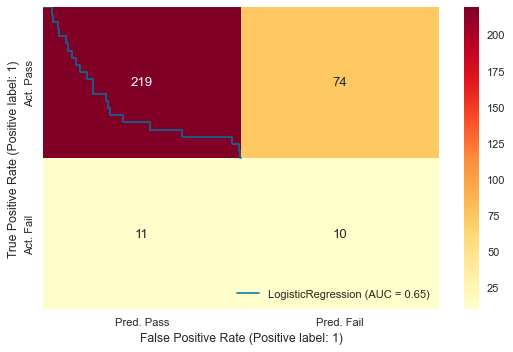

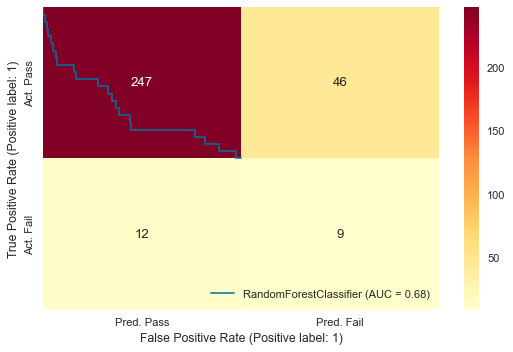

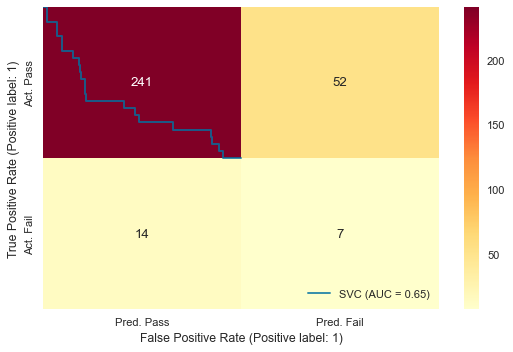

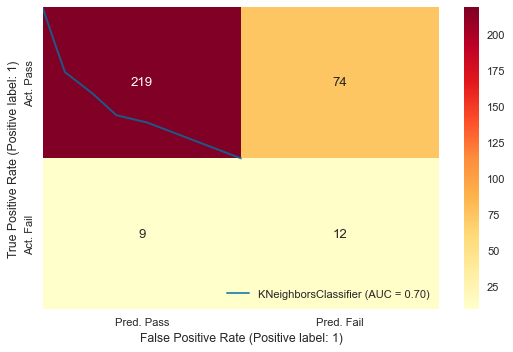

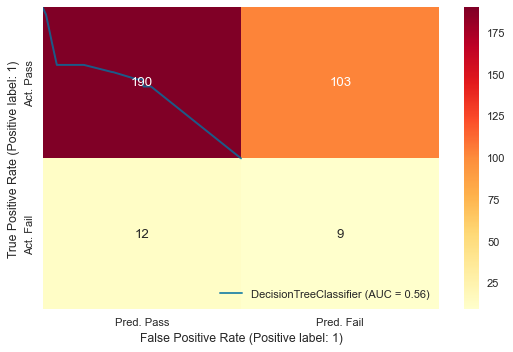

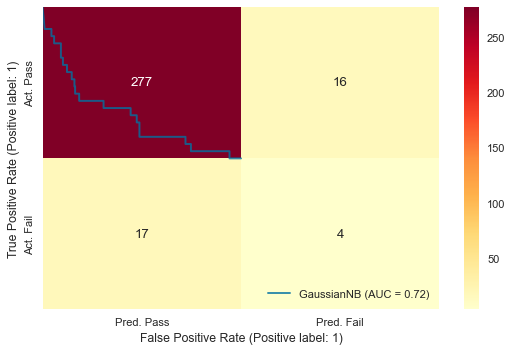

In [117]:
evaluate2(LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear'),X_adasyn,X_test_chi,y_adasyn,y_test)
evaluate2(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_adasyn,X_test_chi,y_adasyn,y_test)
evaluate2(svm.SVC(),X_adasyn,X_test_chi,y_adasyn,y_test)
evaluate2(KNeighborsClassifier(n_neighbors=5),X_adasyn,X_test_chi,y_adasyn,y_test)
evaluate2(DecisionTreeClassifier(criterion='entropy', max_depth=6),X_adasyn,X_test_chi,y_adasyn,y_test)
evaluate2(GaussianNB(),X_adasyn,X_test_chi,y_adasyn,y_test)

## Rose

In [118]:
# Imbalance treatment
X_rose, y_rose = Sampling(X_train_chi, y_train,'ROSE')

Counter({'Classification': 1})


Model Name: LogisticRegression(C=200, class_weight='balanced', random_state=42,
                   solver='liblinear')
Train Accuracy Score: 0.7051282051282052
Test Accuracy Score: 0.7452229299363057
F1 Score: 0.7452229299363057
MC Score: 0.18643890084413106
Sensitivity: 0.961038961038961
Specificity: 0.14457831325301204
Recall: 0.5714285714285714
Precision: 0.14457831325301204
FNR: 0.03896103896103896
FPR: 0.8554216867469879

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
Train Accuracy Score: 0.9662393162393162
Test Accuracy Score: 0.9299363057324841
F1 Score: 0.9299363057324841
MC Score: -0.015132255601226411
Sensitivity: 0.9329073482428115
Specificity: 0.0
Recall: 0.0
Precision: 0.0
FNR: 0.0670926517571885
FPR: 1.0

Model Name: SVC()
Train Accuracy Score: 0.9564102564102565
Test Accuracy Score: 0.910828025477707
F1 Score: 0.910828025477707
MC Score: 0.17912860435413347
Sensitivity: 0.94314381270

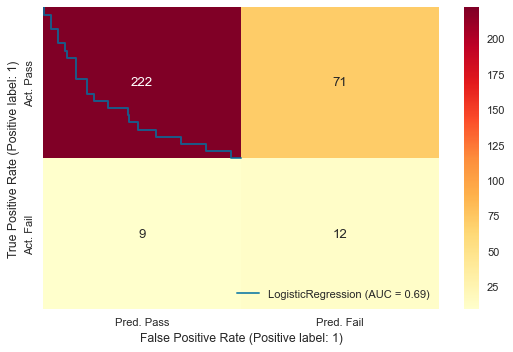

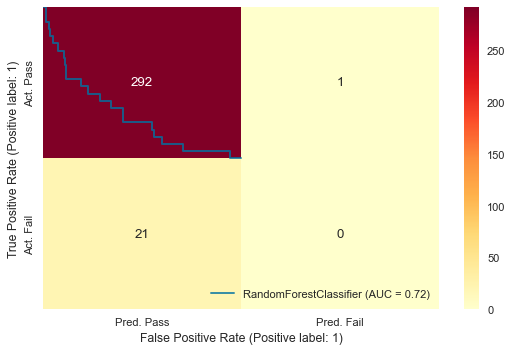

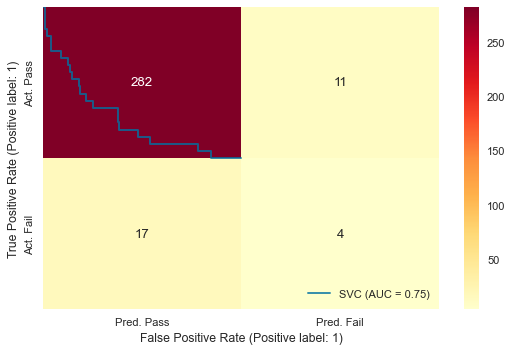

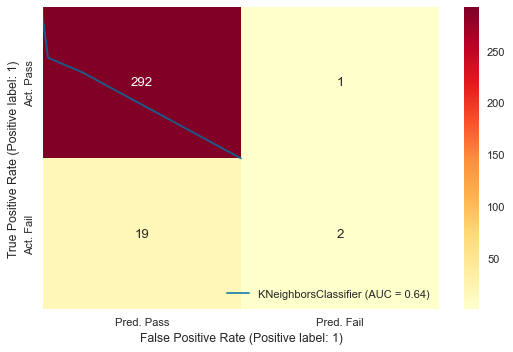

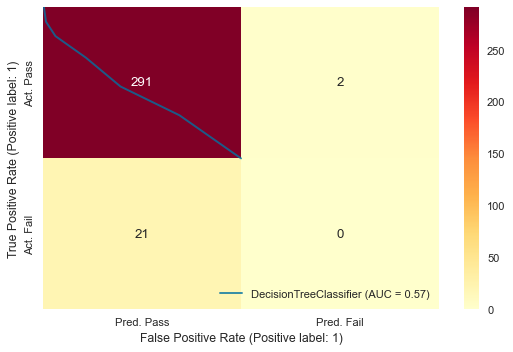

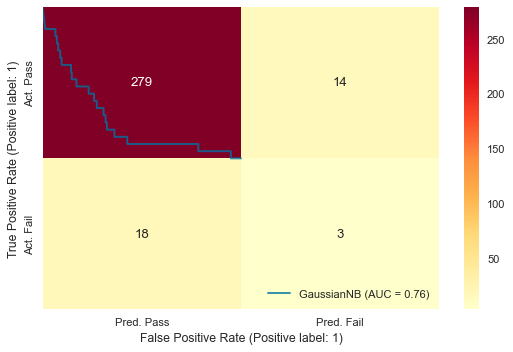

In [119]:
evaluate2(LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear'),X_rose,X_test_chi,y_rose,y_test)
evaluate2(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_rose,X_test_chi,y_rose,y_test)
evaluate2(svm.SVC(),X_rose,X_test_chi,y_rose,y_test)
evaluate2(KNeighborsClassifier(n_neighbors=5),X_rose,X_test_chi,y_rose,y_test)
evaluate2(DecisionTreeClassifier(criterion='entropy', max_depth=6),X_rose,X_test_chi,y_rose,y_test)
evaluate2(GaussianNB(),X_rose,X_test_chi,y_rose,y_test)